Exercise -09

190539T Sajeepan.T


In [31]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

Question -01

(-0.5, 479.5, 639.5, -0.5)

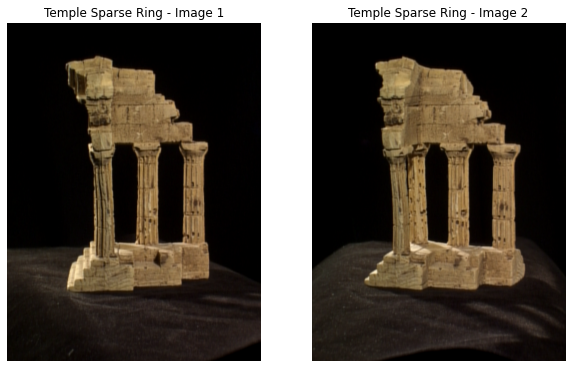

In [32]:
f = open(r'templeSparseRing/templeSR_par.txt', 'r')
assert f is not None

n = int(f.readline())

# Reading the information of the first image
l = f.readline().split()
im1_fn = l[0]
K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

# Reading the information of the second image
l = f.readline().split()
im2_fn = l[0]
K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

# Read the two images and show
im1 = cv.imread(r'templeSparseRing/' + im1_fn, cv.IMREAD_COLOR)
assert im1 is not None
im2 = cv.imread(r'templeSparseRing/' + im2_fn, cv.IMREAD_COLOR)
assert im2 is not None


fig, ax = plt.subplots(1, 2, figsize = (10,8))
im1_n = np.rot90(cv.cvtColor(im1, cv.COLOR_BGR2RGB),k=1)
ax[0].imshow(im1_n)
ax[0].set_title('Temple Sparse Ring - Image 1')
ax[0].axis('off')
im2_n = np.rot90(cv.cvtColor(im2, cv.COLOR_BGR2RGB),k=1)
ax[1].imshow(im2_n)
ax[1].set_title('Temple Sparse Ring - Image 2')
ax[1].axis('off')

In [33]:
sift = cv.xfeatures2d.SIFT_create()
kp1, decs1 = sift.detectAndCompute(im1, None)
kp2, decs2 = sift.detectAndCompute(im2, None)

points1 = np.array(cv.KeyPoint_convert(kp1))
print("Points 1 =",points1)
points2 = np.array(cv.KeyPoint_convert(kp2))
print("Points 2 =",points2)

Points 1 = [[ 13.0532055 117.93448  ]
 [ 19.927507  123.60333  ]
 [108.252266   96.32402  ]
 ...
 [575.7586    139.68608  ]
 [575.9352    159.6251   ]
 [578.3364    184.21379  ]]
Points 2 = [[ 41.017296 330.72073 ]
 [ 58.990788 194.78354 ]
 [ 58.990788 194.78354 ]
 ...
 [571.19086  173.26408 ]
 [571.19086  173.26408 ]
 [574.2256   165.52284 ]]


In [34]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 100)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(decs1, decs2, k=2)

Question -02

In [35]:
good = []
pts1 = []
pts2 = []

for i, (m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)

F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)
print("Fundamental matrix =",F)

E = K2.T @ F @ K1 
print("Essential Matrix =",E)

Fundamental matrix = [[ 1.49034037e-06  1.44154168e-05 -2.53948320e-02]
 [-8.25788252e-06  8.67005344e-08  4.00767127e-03]
 [ 2.27526901e-02 -7.28270380e-03  1.00000000e+00]]
Essential Matrix = [[ 3.44509489e+00  3.34434549e+01 -3.25145725e+01]
 [-1.91581088e+01  2.01870994e-01  2.33852108e+00]
 [ 3.21786978e+01 -4.43004055e+00 -6.22266684e-03]]


Question -03

In [36]:

retval, R, t, mask = cv.recoverPose(E, pts1, pts2, K1) 

R_t_1 = np.concatenate((R1,t1), axis=1) 
R2_ = R1 @ R
t2_ = R1 @ t
R_t_2 = np.concatenate((R2_,t2_), axis=1) 

P1 = K1 @ np.hstack((R1, t1)) 
P2_ = K2 @ R_t_2 

print("Second camera matrix =",P2_)

Second camera matrix = [[ 1.58524669e+02  1.53324446e+03 -1.64453374e+02 -9.53099575e+02]
 [ 1.53407871e+03 -1.25194936e+02 -1.42282633e+02  4.27897189e+01]
 [ 7.55162306e-02  8.27859886e-02 -9.93702057e-01  6.49896959e-01]]


Question -04

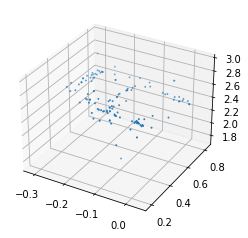

In [37]:
points4d = cv.triangulatePoints(P1,P2_, pts1.T, pts2.T)
points4d /= points4d[3,:]

X = points4d[0,:]
Y = points4d[1,:]
Z = points4d[2,:]

fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X, Y, Z, s=1, cmap='gray')

plt.show()